In [4]:
## testing for Insulin cases by splitting data into two different sets 
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from patsy import dmatrices
from statsmodels.formula.api import glm
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt
from statsmodels.stats.outliers_influence import variance_inflation_factor


In [5]:
# Load the data into a DataFrame; testinginsulin
df = pd.read_csv('/Users/khushbooteotia/Documents/machineLearningTest/cleanseddata.csv')


In [6]:
#cleansing temperature_mean
df['temperature_mean'] = df['temperature_mean'].apply(lambda x: 0 if x < 32 else x)
df['temperature_mean'] = df['temperature_mean'].apply(lambda x: 0 if x > 45 else x)
df['temperature_mean'] = df['temperature_mean'].apply(lambda x: 36.5 if x == 0 or pd.isna(x) else x)

# MBP
df['mbp_mean'] = df['mbp_mean'].apply(lambda x: 0 if x < 0 else x)
df['mbp_mean'] = df['mbp_mean'].apply(lambda x: 0 if x > 200 else x)
df['mbp_mean'] = df['mbp_mean'].apply(lambda x: 85 if x == 0 or pd.isna(x) else x)

In [7]:
len(df)

24927

In [8]:
df.fillna(0, inplace=True)  # Account for NaNs in subset

In [9]:
df['diabetes_types'] = df['diabetes_types'].replace(0, 'none')
df['diabetes_types'] = df['diabetes_types'].replace(1.0, 'one')
df['diabetes_types'] = df['diabetes_types'].replace(2.0, 'two')
categorical_vars = ['diabetes_types']
dummy_vars1 = pd.get_dummies(df[categorical_vars])
df = pd.concat([df, dummy_vars1], axis=1)

df.head()

,subject_id,hadm_id,stay_id,first_careunit,last_careunit,intime,outtime,los,race,language,...,ph_min,po2_min,spo2_mean,resp_rate_mean,heart_rate_mean,temperature_mean,mbp_mean,diabetes_types_none,diabetes_types_one,diabetes_types_two
0,14223179,28962684,31389905,Neuro Stepdown,Neuro Surgical Intensive Care Unit (Neuro SICU),2189-01-08 09:35:00,2189-01-10 21:04:47,2.479016,WHITE,ENGLISH,...,7.35,90.0,95.375000,17.312500,73.500000,36.454000,106.333333,True,False,False
1,19611589,27643931,32371355,Neuro Stepdown,Neuro Stepdown,2174-11-19 22:27:00,2174-11-22 19:32:18,2.878681,WHITE,ENGLISH,...,7.35,90.0,95.111111,18.555556,94.260870,36.668571,102.125000,False,False,True
2,19147123,27351170,34740339,Neuro Stepdown,Neuro Stepdown,2171-11-16 11:28:51,2171-11-22 15:44:44,6.177697,BLACK/AFRICAN AMERICAN,ENGLISH,...,7.35,90.0,93.526316,23.894737,87.222222,37.256000,110.500000,False,False,True
3,15617454,24021087,35826606,Neuro Stepdown,Neuro Stepdown,2168-05-31 10:12:13,2168-06-12 17:49:01,12.317222,ASIAN - CHINESE,?,...,7.35,90.0,96.600000,15.333333,70.933333,36.855714,96.529412,True,False,False
4,10096175,21035896,31525858,Neuro Intermediate,Neuro Surgical Intensive Care Unit (Neuro SICU),2135-01-10 18:29:19,2135-01-16 21:27:03,6.123426,WHITE,ENGLISH,...,7.35,90.0,91.941176,20.550000,72.700000,37.120000,83.725000,False,False,True


In [10]:
categorical_vars2 = ['gender']
dummy_vars = pd.get_dummies(df[categorical_vars2])
sex_df = pd.concat([df, dummy_vars], axis=1)

sex_df.fillna(0, inplace=True)

sex_df.head()

,subject_id,hadm_id,stay_id,first_careunit,last_careunit,intime,outtime,los,race,language,...,spo2_mean,resp_rate_mean,heart_rate_mean,temperature_mean,mbp_mean,diabetes_types_none,diabetes_types_one,diabetes_types_two,gender_F,gender_M
0,14223179,28962684,31389905,Neuro Stepdown,Neuro Surgical Intensive Care Unit (Neuro SICU),2189-01-08 09:35:00,2189-01-10 21:04:47,2.479016,WHITE,ENGLISH,...,95.375000,17.312500,73.500000,36.454000,106.333333,True,False,False,False,True
1,19611589,27643931,32371355,Neuro Stepdown,Neuro Stepdown,2174-11-19 22:27:00,2174-11-22 19:32:18,2.878681,WHITE,ENGLISH,...,95.111111,18.555556,94.260870,36.668571,102.125000,False,False,True,False,True
2,19147123,27351170,34740339,Neuro Stepdown,Neuro Stepdown,2171-11-16 11:28:51,2171-11-22 15:44:44,6.177697,BLACK/AFRICAN AMERICAN,ENGLISH,...,93.526316,23.894737,87.222222,37.256000,110.500000,False,False,True,False,True
3,15617454,24021087,35826606,Neuro Stepdown,Neuro Stepdown,2168-05-31 10:12:13,2168-06-12 17:49:01,12.317222,ASIAN - CHINESE,?,...,96.600000,15.333333,70.933333,36.855714,96.529412,True,False,False,False,True
4,10096175,21035896,31525858,Neuro Intermediate,Neuro Surgical Intensive Care Unit (Neuro SICU),2135-01-10 18:29:19,2135-01-16 21:27:03,6.123426,WHITE,ENGLISH,...,91.941176,20.550000,72.700000,37.120000,83.725000,False,False,True,True,False


In [11]:
# Assuming your DataFrame is named 'df'
sex_df['language'] = sex_df['language'].replace({"?": 1, "ENGLISH": 0})
sex_df.head()


,subject_id,hadm_id,stay_id,first_careunit,last_careunit,intime,outtime,los,race,language,...,spo2_mean,resp_rate_mean,heart_rate_mean,temperature_mean,mbp_mean,diabetes_types_none,diabetes_types_one,diabetes_types_two,gender_F,gender_M
0,14223179,28962684,31389905,Neuro Stepdown,Neuro Surgical Intensive Care Unit (Neuro SICU),2189-01-08 09:35:00,2189-01-10 21:04:47,2.479016,WHITE,0,...,95.375000,17.312500,73.500000,36.454000,106.333333,True,False,False,False,True
1,19611589,27643931,32371355,Neuro Stepdown,Neuro Stepdown,2174-11-19 22:27:00,2174-11-22 19:32:18,2.878681,WHITE,0,...,95.111111,18.555556,94.260870,36.668571,102.125000,False,False,True,False,True
2,19147123,27351170,34740339,Neuro Stepdown,Neuro Stepdown,2171-11-16 11:28:51,2171-11-22 15:44:44,6.177697,BLACK/AFRICAN AMERICAN,0,...,93.526316,23.894737,87.222222,37.256000,110.500000,False,False,True,False,True
3,15617454,24021087,35826606,Neuro Stepdown,Neuro Stepdown,2168-05-31 10:12:13,2168-06-12 17:49:01,12.317222,ASIAN - CHINESE,1,...,96.600000,15.333333,70.933333,36.855714,96.529412,True,False,False,False,True
4,10096175,21035896,31525858,Neuro Intermediate,Neuro Surgical Intensive Care Unit (Neuro SICU),2135-01-10 18:29:19,2135-01-16 21:27:03,6.123426,WHITE,0,...,91.941176,20.550000,72.700000,37.120000,83.725000,False,False,True,True,False


In [12]:
categorical_vars1 = ['race_group']
dummy_vars = pd.get_dummies(sex_df[categorical_vars1])
race_df = pd.concat([sex_df, dummy_vars], axis=1)

race_df.fillna(0, inplace=True)

race_df.head()

,subject_id,hadm_id,stay_id,first_careunit,last_careunit,intime,outtime,los,race,language,...,mbp_mean,diabetes_types_none,diabetes_types_one,diabetes_types_two,gender_F,gender_M,race_group_Asian,race_group_Black,race_group_Hispanic,race_group_White
0,14223179,28962684,31389905,Neuro Stepdown,Neuro Surgical Intensive Care Unit (Neuro SICU),2189-01-08 09:35:00,2189-01-10 21:04:47,2.479016,WHITE,0,...,106.333333,True,False,False,False,True,False,False,False,True
1,19611589,27643931,32371355,Neuro Stepdown,Neuro Stepdown,2174-11-19 22:27:00,2174-11-22 19:32:18,2.878681,WHITE,0,...,102.125000,False,False,True,False,True,False,False,False,True
2,19147123,27351170,34740339,Neuro Stepdown,Neuro Stepdown,2171-11-16 11:28:51,2171-11-22 15:44:44,6.177697,BLACK/AFRICAN AMERICAN,0,...,110.500000,False,False,True,False,True,False,True,False,False
3,15617454,24021087,35826606,Neuro Stepdown,Neuro Stepdown,2168-05-31 10:12:13,2168-06-12 17:49:01,12.317222,ASIAN - CHINESE,1,...,96.529412,True,False,False,False,True,True,False,False,False
4,10096175,21035896,31525858,Neuro Intermediate,Neuro Surgical Intensive Care Unit (Neuro SICU),2135-01-10 18:29:19,2135-01-16 21:27:03,6.123426,WHITE,0,...,83.725000,False,False,True,True,False,False,False,False,True


Training data set length=17448
Testing data set length=7479


                 Generalized Linear Model Regression Results                  
Dep. Variable:       totalgluc_perLOS   No. Observations:                17448
Model:                            GLM   Df Residuals:                    17415
Model Family:        NegativeBinomial   Df Model:                           32
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -53172.
Date:                Thu, 27 Jul 2023   Deviance:                       3038.4
Time:                        14:15:14   Pearson chi2:                 3.86e+03
No. Iterations:                    19   Pseudo R-squ. (CS):            0.08585
Covariance Type:            nonrobust                                         
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

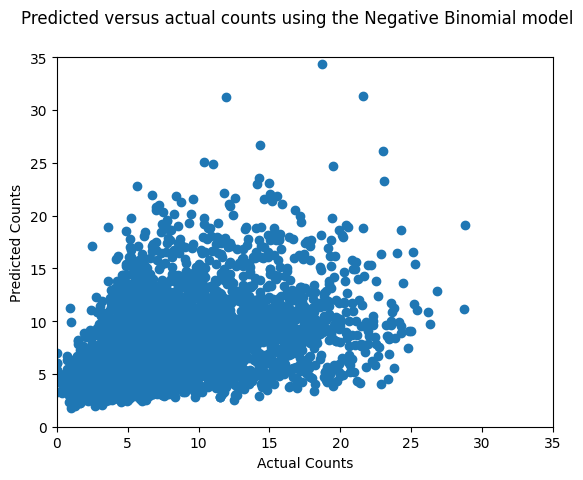

In [13]:

split_index = int(len(race_df) * 0.7)  # 80% for training, 20% for testing

race_df_train = race_df[:split_index]
race_df_test = race_df[split_index:]
print('Training data set length=' + str(len(race_df_train)))
print('Testing data set length=' + str(len(race_df_test)))

expr = 'totalgluc_perLOS ~ temperature_mean + spo2_mean + heart_rate_mean + mbp_mean + hadInsulinDayOne + connective_disease + resp_rate_mean + po2_min + copd_present + language + cad_present + heart_failure_present + gender_F + admElective + anchor_year_group + biliary + pneumonia + uti + ckd_stages + asthma_present + age + SOFA + charlson_comorbidity_index + diabetes_types_one + diabetes_types_two + race_group_Asian + race_group_Black + race_group_Hispanic + skin + hadMeasurmentDayOne'

y_train, X_train = dmatrices(expr, race_df_train, return_type='dataframe')
y_test, X_test = dmatrices(expr, race_df_test, return_type='dataframe')

# Creating the Negative Binomial model
nb_training_results = sm.GLM(y_train, X_train, family = sm.families.NegativeBinomial(alpha = 2)).fit()


print(nb_training_results.summary())

# Extract coefficient names and values
coef_names = nb_training_results.params.index
coef_values = nb_training_results.params.values

# Calculate exponentiated coefficients
coef_exp = np.exp(coef_values)
print(coef_exp)

negbin_predictions = nb_training_results.predict(X_test)
predicted_counts = negbin_predictions
actual_counts = y_test['totalgluc_perLOS']

# Calculate RMSE for the negative binomial model
rmse = np.sqrt(np.mean(np.power(predicted_counts - actual_counts, 2)))
print('Negative Binomial RMSE=', rmse)

# Calculate R-squared for count data models
total_var = np.sum(np.power(actual_counts - np.mean(actual_counts), 2))
deviance = np.sum(np.power(actual_counts - predicted_counts, 2))
r2_count = 1 - (deviance / total_var)
print("R-squared (Count Data Models):", r2_count)


#Accuracy of the test set

print("R-square of train set: ", round(r2_score(y_test, predicted_counts)*100, 2), "%")

# Creating and plotting the graph
fig = plt.figure()
fig.suptitle('Predicted versus actual counts using the Negative Binomial model')
plt.scatter(actual_counts, predicted_counts)
plt.xlabel('Actual Counts')
plt.ylabel('Predicted Counts')
plt.ylim(0,35)
plt.xlim(0,35)
plt.show()


In [25]:
import numpy as np
import pandas as pd

# Assuming you have the results from nb_training_results.summary2()
# Replace the following line with the actual summary results from your model
summary_table = nb_training_results.summary2().tables[1]


# Extract the CI columns from the summary table and create a copy
coef_table = summary_table[['[0.025', '0.975]']].copy()

# Exponentiate the CI values using np.exp()
LCI_exp = np.exp(coef_table['[0.025'])
UCI_exp = np.exp(coef_table['0.975]'])

# Add the exponentiated CI values to the DataFrame as new columns
coef_table['Lower_CI_exp'] = LCI_exp
coef_table['Upper_CI_exp'] = UCI_exp

#Inserting exponentiating coefficients
coef_table.insert(0, 'IRR', coef_exp)

# Drop the original non-exponentiated CI columns
coef_table.drop(columns=['[0.025', '0.975]'], inplace=True)

# Round the values in the DataFrame to a specified number of decimal places (e.g., 5)
coef_table = coef_table.round(5)

# Display the table
print(coef_table)

# Download as a CSV file
# coef_table.to_csv('exponentiated_CI_results.csv', index=False)


                                        IRR  Lower_CI_exp  Upper_CI_exp
Intercept                         510.44326      86.67229    3006.17771
hadInsulinDayOne[T.True]            1.90803       1.81729       2.00330
gender_F[T.True]                    0.91049       0.87005       0.95280
admElective[T.True]                 1.64582       1.48030       1.82985
anchor_year_group[T.2011 - 2013]    1.00514       0.95042       1.06302
anchor_year_group[T.2014 - 2016]    1.07343       1.01002       1.14082
anchor_year_group[T.2017 - 2019]    0.99971       0.92290       1.08292
diabetes_types_one[T.True]          2.02425       1.65497       2.47592
diabetes_types_two[T.True]          1.35608       1.24139       1.48137
race_group_Asian[T.True]            0.98421       0.85952       1.12699
race_group_Black[T.True]            1.03328       0.96039       1.11170
race_group_Hispanic[T.True]         1.02650       0.90837       1.16000
hadMeasurmentDayOne[T.True]         0.95972       0.88935       

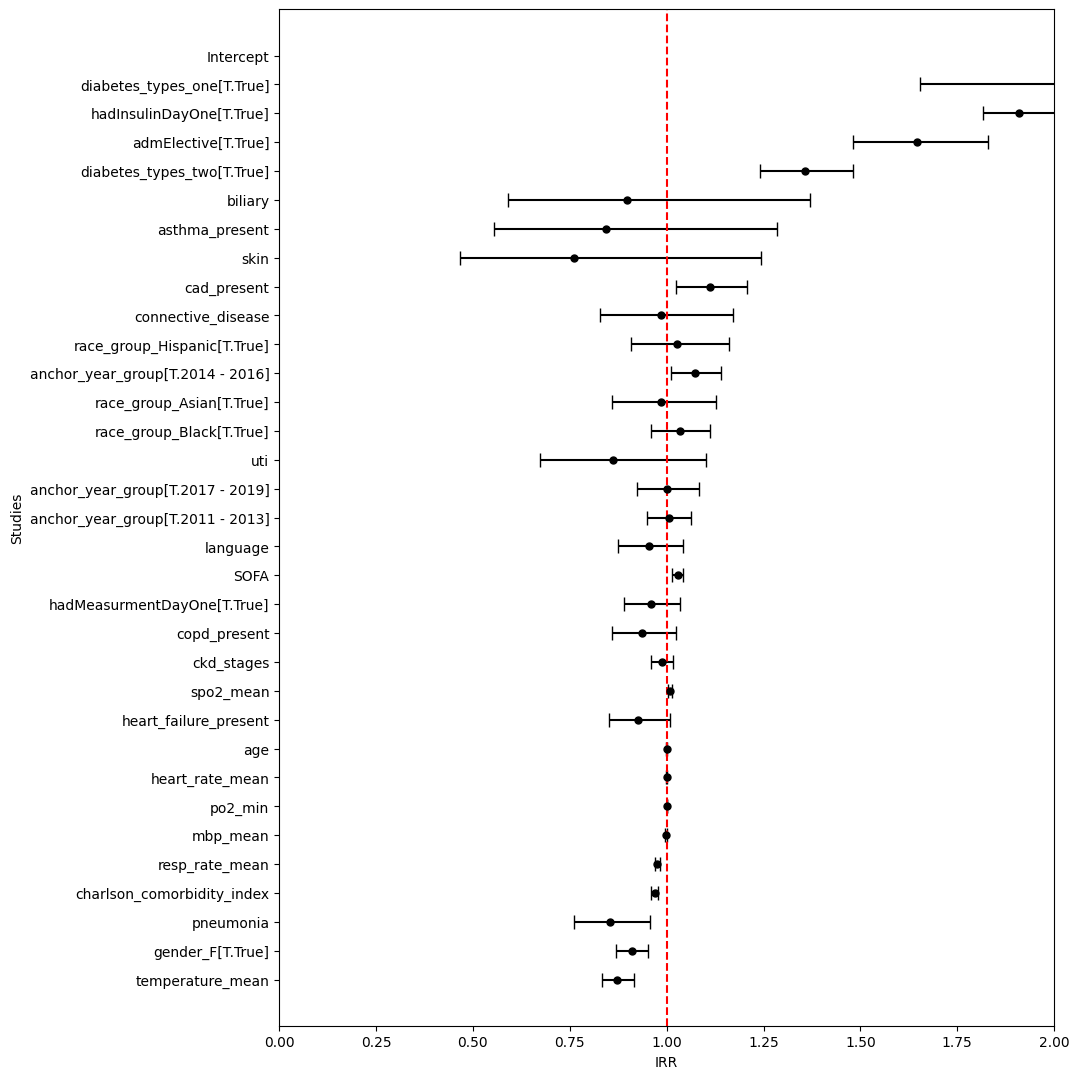

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have the DataFrame 'coef_table' with columns: 'IRR', 'Lower_CI_exp', 'Upper_CI_exp'
coef_table = coef_table.sort_values(by='Upper_CI_exp', ascending=True)

plt.figure(figsize=(10, len(coef_table) * 0.4))  # Adjust the figure size according to your preference

# Calculate the errors for error bars without taking the absolute value
lower_errors = coef_table['IRR'] - coef_table['Lower_CI_exp']
upper_errors = coef_table['Upper_CI_exp'] - coef_table['IRR']

# Create the forest plot with error bars
plt.errorbar(coef_table['IRR'], range(len(coef_table)), xerr=[lower_errors, upper_errors],
             linestyle='', marker='o', markersize=5, capsize=5, color='black')

# Set the y-ticks and labels
plt.yticks(range(len(coef_table)), coef_table.index)
plt.axvline(x=1, color='red', linestyle='--', label='IRR = 1')

# Set the labels for x and y axes
plt.xlabel('IRR')
plt.ylabel('Studies')
plt.xlim(0, 2)

# Show the plot
plt.show()


In [ ]:
def calculate_vif(race_df):
    # Create a DataFrame to store the VIF values
    vif_data = pd.DataFrame()
    vif_data["Feature"] = race_df.columns
    vif_data["VIF"] = [variance_inflation_factor(race_df.values, i) for i in range(race_df.shape[1])]
    return vif_data

# Assuming 'X_train' is a DataFrame containing the predictor variables
vif_result = calculate_vif(X_train)
print(vif_result)


                             Feature          VIF
0                          Intercept  6417.436657
1           hadInsulinDayOne[T.True]     1.162566
2                   gender_F[T.True]     1.044294
3                admElective[T.True]     1.047559
4   anchor_year_group[T.2011 - 2013]     1.211580
5   anchor_year_group[T.2014 - 2016]     1.258954
6   anchor_year_group[T.2017 - 2019]     1.343026
7         diabetes_types_one[T.True]     1.078753
8         diabetes_types_two[T.True]     1.450264
9           race_group_Asian[T.True]     1.174791
10          race_group_Black[T.True]     1.091721
11       race_group_Hispanic[T.True]     1.229744
12       hadMeasurmentDayOne[T.True]     1.067249
13                  temperature_mean     1.148888
14                         spo2_mean     1.046500
15                   heart_rate_mean     1.282834
16                          mbp_mean     1.129485
17                connective_disease     1.044936
18                    resp_rate_mean     1.268468
